In [198]:
# import stuff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os

import cv2

import scipy
from scipy import signal
import h5py, time
from iminuit import Minuit, describe
from pprint import pprint # we use this to pretty print some stuff later
import glob
import pandas as pd
import sys
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile
from discharge_tools import *
from AnaUtil import *
from bisect import bisect_left
from tqdm import tqdm

from joblib import Parallel, delayed
import multiprocessing
import datetime as dt
plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.labelsize'] = "small"
plt.rcParams['ytick.labelsize'] = 36

In [2]:
def shift_correct(input_pos,idx):
    output_pos = np.insert(input_pos,0,np.linspace(0,0,idx))
    return output_pos

def gaussian(data_x,params=list):
    norm = (1/((1/2*params[2])*np.sqrt(np.pi * 2)))
    return params[0] * norm * np.exp(-(np.subtract(data_x,params[1])**2/(2*params[2]**2)))+params[3]

def gaussian_cdf(data_x,params=list):
    # for normalization a 1/sigma could be needed
    return params[0]*0.5*(1+scipy.special.erf((data_x-params[1])/(np.sqrt(2)*params[2])))+params[3]

def linear(data_x,params=list):
    return params[0]*data_x+params[1]

def chisquare_1d(function, functionparams, data_x, data_y,data_y_error):
    chisquarevalue=np.sum(np.power(np.divide(np.subtract(function(data_x,functionparams),data_y),data_y_error),2))
    ndf = len(data_y)-len(functionparams)
    #print(ndf)
    return (chisquarevalue, ndf)

def chisquare_linear(a,b):
    return chisquare_1d(function=linear,functionparams=[a,b],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]

def chisquare_gaussian(area,mean,sigma,constant):
    return chisquare_1d(function=gaussian,functionparams=[area,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]

def chisquare_gaussian_cdf(amp,mean,sigma,constant):
    return chisquare_1d(function=gaussian_cdf,functionparams=[amp,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]

In [3]:
# calibration of the voltage - position conversion

def voltage_to_position(voltage,slope=0.019834000085488412,offset=-0.0015000315197539749,redo=False):
    if(redo==True):
        pos_list=np.asarray([-0.007,4.968,9.91])
        y_err=np.asarray([0.01,0.01,0.01])
        val = np.asarray([0,250,500])
        data_x=val
        data_y=pos_list
        data_y_error=y_err
        m2=Minuit(chisquare_linear, 
             a = 100,
             b=0,
             errordef = 1,
             print_level=1)
        m2.migrad()
        print(m2.values["a"],m2.values["b"])
        plt.plot(val,pos_list,marker="*")
        plt.plot(val,m2.values["a"]*val+m2.values["b"])
        slope = m2.values["a"]
        offset = m2.values["b"]
    position=(voltage-offset)/slope
    return position

In [4]:
def get_average_mean_position(var_list,axis="x"):
    position_list = []
    sigma_list=[]
    def chisquare_gaussian_cdf(amp,mean,sigma,constant):
        return chisquare_1d(function=gaussian_cdf,functionparams=[amp,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]
    
    for i in tqdm(np.arange(0,len(var_list[0]),1)):#len(file_list),1):
        if(axis=="x"):
            amp_guess=-1.5e9
            mean_guess=7.95
            sigma_guess=0.3e-1
            constant_guess=0.9e9
        elif(axis=="y"):
            amp_guess=1.8e9
            mean_guess= 7.9
            sigma_guess=0.3e-1
            constant_guess=0.9e9 

        data_x = var_list[0][i] # give x data using X shaking
        data_y = var_list[1][i]# give y data 
        data_y_error = np.sqrt(np.abs(data_y)) # give y uncertainty  
        m=Minuit(chisquare_gaussian_cdf, amp = amp_guess, # set start parameter
         #limit_area= (limit_lower,limit_upper) # if you want to limit things
         #limit_amp = (amp_guess/5,amp_guess*5), # you can also fix it
         mean = mean_guess,
         #fix_mean = "True",
         #limit_mean = (3500,4500),
         sigma = sigma_guess,
         limit_sigma=(sigma_guess/10,sigma_guess*10),
         constant = constant_guess,
         #fix_constant="True",
         errordef = 1,
         print_level=0,pedantic=False)
         #print('Now proceed with the fit.')
        try:m.migrad(ncall=500000)
        except:print("Nope, fit %d did not work." %i)
        #print(m.values["amp"])
        position_list.append(voltage_to_position(m.values["mean"]))
        sigma_list.append(m.values["sigma"])
        #plt.plot(voltage_to_position(data_x),data_y)
        #plt.plot(voltage_to_position(data_x),gaussian_cdf(data_x,params=[m.values["amp"],(m.values["mean"]),m.values["sigma"],m.values["constant"]]),alpha=1)
        #plt.show() 
    return position_list,np.mean(position_list),np.std(position_list),sigma_list


In [85]:
def fit_cdf(data):
    position_list = []
    def chisquare_gaussian_cdf(amp,mean,sigma,constant):
        return chisquare_1d(function=gaussian_cdf,functionparams=[amp,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]    
    
    #if(axis=="x"):
    amp_guess=-1.5e9
    mean_guess=7.95
    sigma_guess=0.3e-1
    constant_guess=0.9e9
    #elif(axis=="y"):
        #amp_guess=1.8e9
        #mean_guess= 7.9
        #sigma_guess=0.3e-1
        #constant_guess=0.9e9 
    data_x = data[0]# give x data using X shaking
    data_y = data[1]# give y data 
    data_y_error = np.sqrt(np.abs(data_y)) # give y uncertainty  
    m=Minuit(chisquare_gaussian_cdf, amp = amp_guess, # set start parameter
     #limit_area= (limit_lower,limit_upper) # if you want to limit things
     #limit_amp = (amp_guess/5,amp_guess*5), # you can also fix it
     mean = mean_guess,
     #fix_mean = "True",
     #limit_mean = (3500,4500),
     sigma = sigma_guess,
     limit_sigma=(sigma_guess/10,sigma_guess*10),
     constant = constant_guess,
     #fix_constant="True",
     errordef = 1,
     print_level=0,pedantic=False)
     #print('Now proceed with the fit.')
    try:m.migrad(ncall=500000)
    except:print("Nope, fit did not work.")
    return voltage_to_position(m.values["mean"])   

In [6]:
def load_dir_reduced_to_pos_and_quad_sum(dirname,file_prefix,max_files,axis="x"):
    '''
    
    '''   
    ## Load all filenames in directory
    if(axis=="x"):axis_int = 0
    if(axis=="y"):axis_int = 1    
    var_list = []
    quad_sum_list = []
    files = []
    [files.append(file_) for file_ in os.listdir(dirname) if file_.startswith(file_prefix) if file_.endswith('.h5')]
    files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))        
    step_size = 1
    if(len(files)<max_files):max_file_limit=len(files)
    else:max_file_limit=max_files
    for j in tqdm(np.arange(0,max_file_limit,step_size)):
        BDFs = [BDF.BeadDataFile(dirname+filename) for filename in files[j:j+step_size]]
        for k in range(len(BDFs)):
            var_list.append(BDFs[k].cant_pos[axis_int])
            quad_sum_list.append(BDFs[k].quad_sum)
            
    return var_list,quad_sum_list 




In [42]:
def load_dir_reduced_to_pos_and_quad_sum_parallelized(dirname,file_prefix,max_files,axis="x",n_jobs=24,step_size=100):
    ## Load all filenames in directory
    if(axis=="x"):axis_int = 0
    if(axis=="y"):axis_int = 1    
    files = []
    pos_list = []
    [files.append(file_) for file_ in os.listdir(dirname) if file_.startswith(file_prefix) if file_.endswith('.h5')]
    files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))        
    step_size=step_size
    if(len(files)<max_files):max_file_limit=len(files)
    else:max_file_limit=max_files
    for j in tqdm(np.arange(0,max_file_limit,step_size)):
        data_list=[]
        BDFs = [BDF.BeadDataFile(dirname+filename) for filename in files[j:j+step_size]]
        for k in range(len(BDFs)):
            data = BDFs[k].cant_pos[axis_int],BDFs[k].quad_sum
            data_list.append(data)
        pos = Parallel(n_jobs=n_jobs)(delayed(fit_cdf)(data) for data in data_list)
        pos_list.append(pos)  
    return pos_list



In [93]:
# load the data
Day = "10"
Month = "02"
Year = "2020"
BeadNumber = 2
#RunNumber = 144
#folder =  r"/data/new_trap/" + Year + Month + Day +"/NoBead/"+"X_Shaking/"
folder = r"/data/new_trap/" + Year + Month + Day +"/Bead%d/" %BeadNumber + "Shaking/"
file_prefix="BeamProfiling"
print(folder)


/data/new_trap/20200210/Bead2/Shaking/


In [94]:
g = load_dir_reduced_to_pos_and_quad_sum_parallelized(folder,file_prefix,100000,axis="x",n_jobs=24,step_size=100)

100%|██████████| 1/1 [00:05<00:00,  5.81s/it]


In [95]:
#394.6 in X 
#428.5 in Y

[[332.8375518335182, 394.5860462465724, 449.85168988379235]]

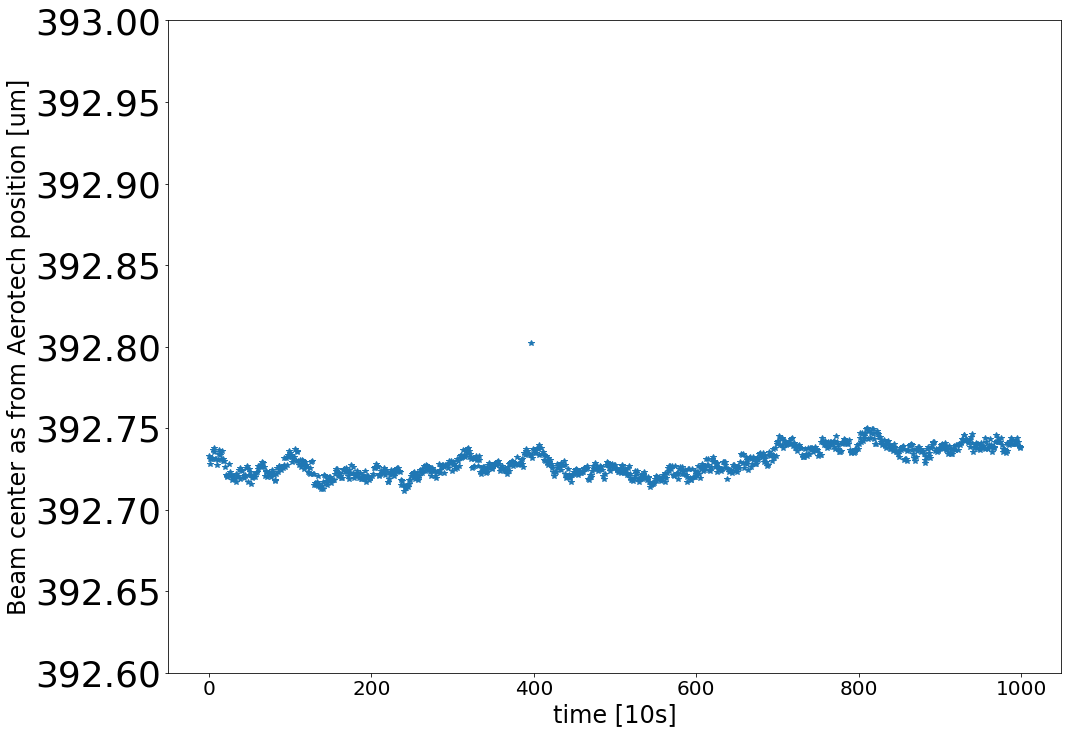

In [203]:
plt.plot(a2,linestyle="",marker="*")
plt.ylim(392.6,393.0)
plt.ylabel("Beam center as from Aerotech position [um]")
plt.xlabel("time [10s]")
plt.savefig("Results/stability_x_after_first_y_20200226.png", dpi=300,bbox_inches="tight")
plt.show()

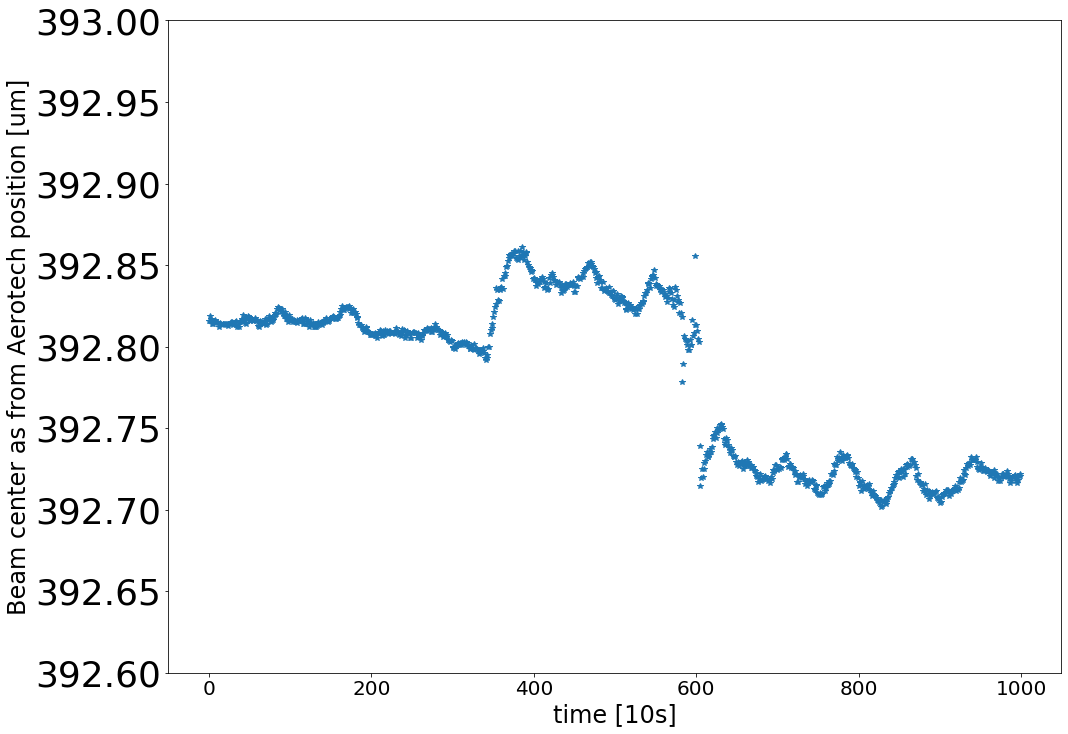

In [204]:
plt.plot(a4,linestyle="",marker="*")
plt.ylim(392.6,393.0)
plt.ylabel("Beam center as from Aerotech position [um]")
plt.xlabel("time [10s]")
plt.savefig("Results/stability_x_after_second_y_20200226.png", dpi=300,bbox_inches="tight")
plt.show()

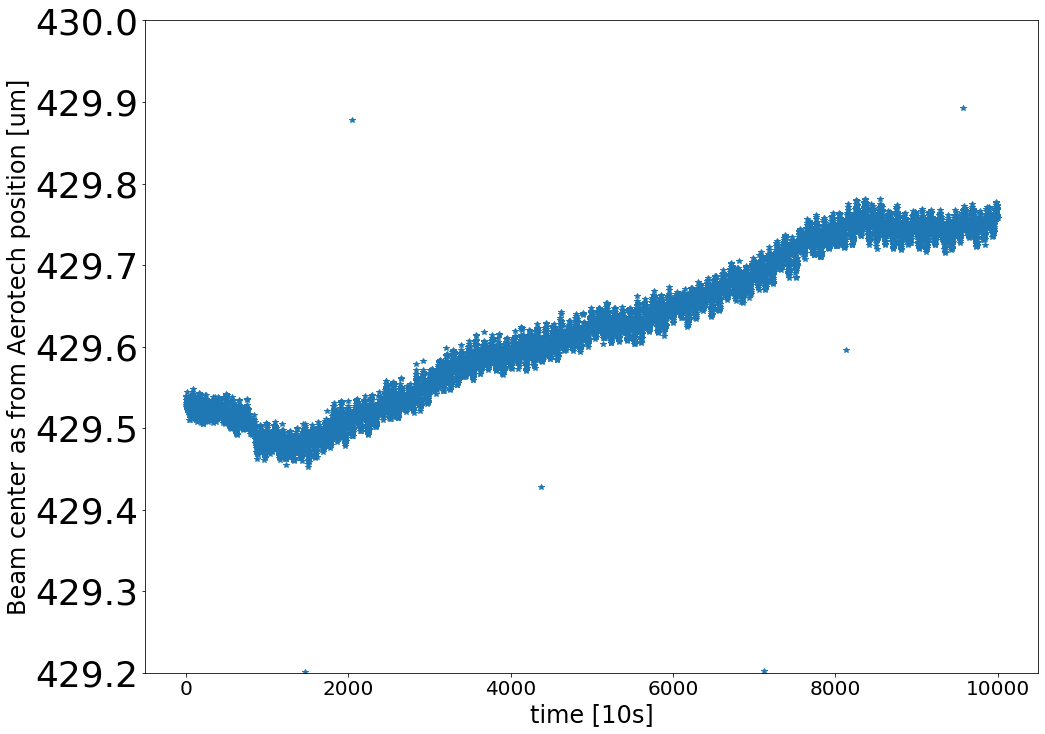

In [214]:
plt.plot(a1,linestyle="",marker="*")
plt.ylim(429.2,430)
#plt.xlim(0,1000)
plt.ylabel("Beam center as from Aerotech position [um]")
plt.xlabel("time [10s]")
plt.savefig("Results/first_y_shaking_20200226.png", dpi=300,bbox_inches="tight")
plt.show()

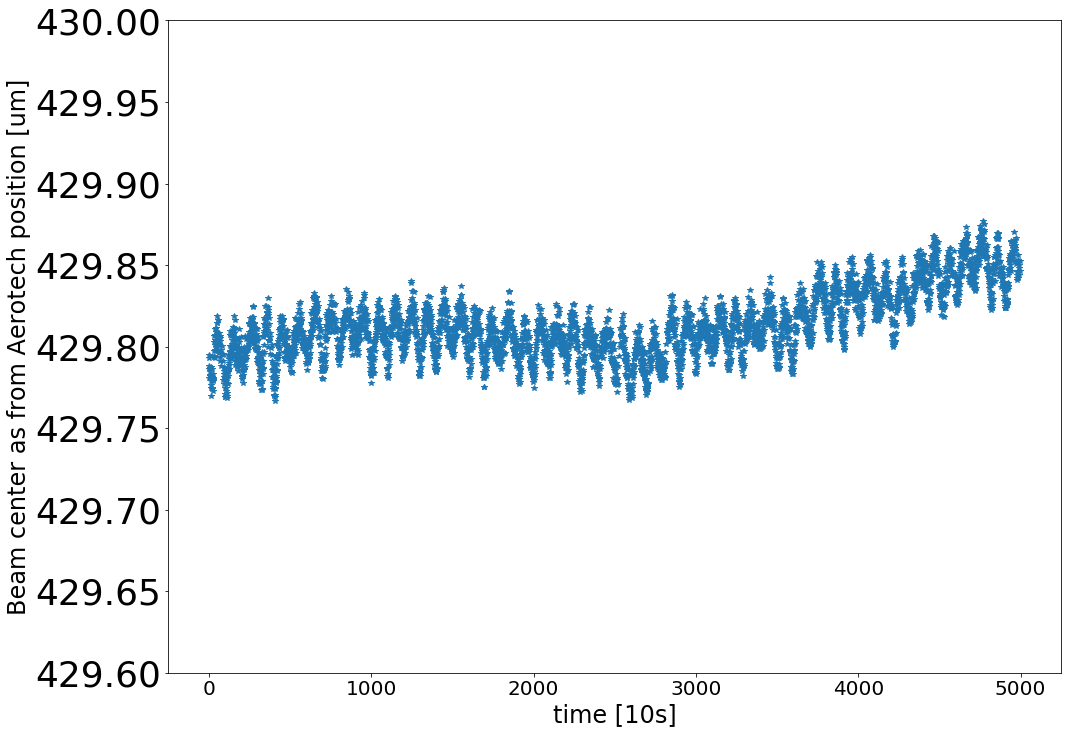

In [215]:
plt.plot(a3,linestyle="",marker="*")
plt.ylim(429.6,430)
plt.ylabel("Beam center as from Aerotech position [um]")
plt.xlabel("time [10s]")
plt.savefig("Results/second_y_shaking_20200226.png", dpi=300,bbox_inches="tight")
plt.show()

In [52]:
a = []
for i in np.arange(0,50,1):
    for j in np.arange(0,100,1):
        a.append(g[i][j])

In [53]:
len(a)

5000

In [55]:
np.savetxt("/data/new_trap/20200222/NoBead/Y_Shaking/Shaking1.txt",a)

In [58]:
a1 = np.loadtxt("/data/new_trap/20200222/NoBead/Y_Shaking/Shaking0.txt")
a2 = np.loadtxt("/data/new_trap/20200222/NoBead/X_Shaking/Shaking0.txt")
a3 = np.loadtxt("/data/new_trap/20200222/NoBead/Y_Shaking/Shaking1.txt")
a4 = np.loadtxt("/data/new_trap/20200222/NoBead/X_Shaking/Shaking1.txt")


(0.999, 1.001)

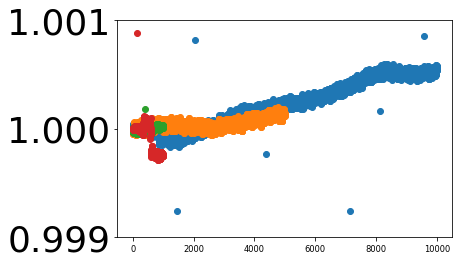

In [79]:
plt.plot(np.divide(a1,a1[0]),marker="o",linestyle="")
plt.plot(np.divide(a3,a3[0]),marker="o",linestyle="")
plt.plot(np.divide(a2,a2[0]),marker="o",linestyle="")
plt.plot(np.divide(a4,a4[0]),marker="o",linestyle="")

plt.ylim(0.999,1.001)

In [88]:
g

[[394.19448301745655,
  394.19567755538566,
  394.1956226423879,
  394.1953851899013,
  394.19357458697,
  394.1925564514967,
  394.1910920191699,
  394.18962634722806,
  394.1920016295924,
  394.1921084430661]]

In [191]:
img = np.load("/data/new_trap/20200222/NoBead/X_Shaking/Pictures_0/Shaking3_6.npy")

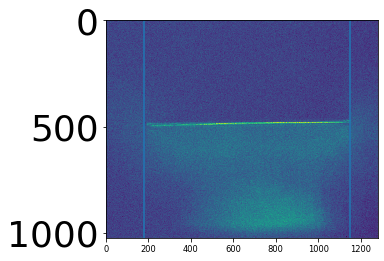

In [192]:
plt.imshow(img)
plt.axvline(180)
plt.axvline(1150)


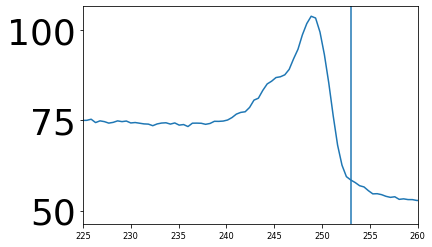

In [196]:
factor = 0.46
x = np.arange(0,1024*factor,factor)
plt.plot(1024*factor-x,np.mean(img,axis=1))
plt.xlim(225,260)
#plt.axvline(249)
plt.axvline(253)

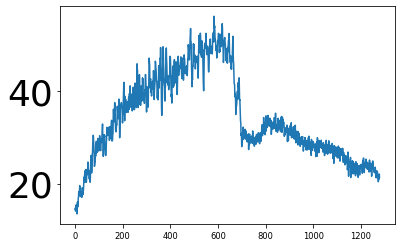

In [164]:
factor = 1
x = np.arange(0,1280*factor,factor)
plt.plot(x,np.mean(img[475:505],axis=0))

In [135]:
1150-180

970

In [431]:
def load_img_files(path):
    # read in the data 
    files = glob.glob(path)
    files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))    

    img_files = []
    for i in range(0,len(files)):
        img_files.append(cv2.imread(files[i],0))
        print(files[i]) 
    return img_files

In [222]:
path = "/data/new_trap/20200226/Bead1/Height_Determination/*bmp"
img = load_img_files(path)

/data/new_trap/20200226/Bead1/Height_Determination/625_20_attr_bead_20200227.bmp
/data/new_trap/20200226/Bead1/Height_Determination/Shield_ROI_20200227.bmp
/data/new_trap/20200226/Bead1/Height_Determination/shield_with_bead_20200227.bmp
/data/new_trap/20200226/Bead1/Height_Determination/250_20_attr_bead_20200227.bmp
/data/new_trap/20200226/Bead1/Height_Determination/778_20_attr_only_20200227.bmp


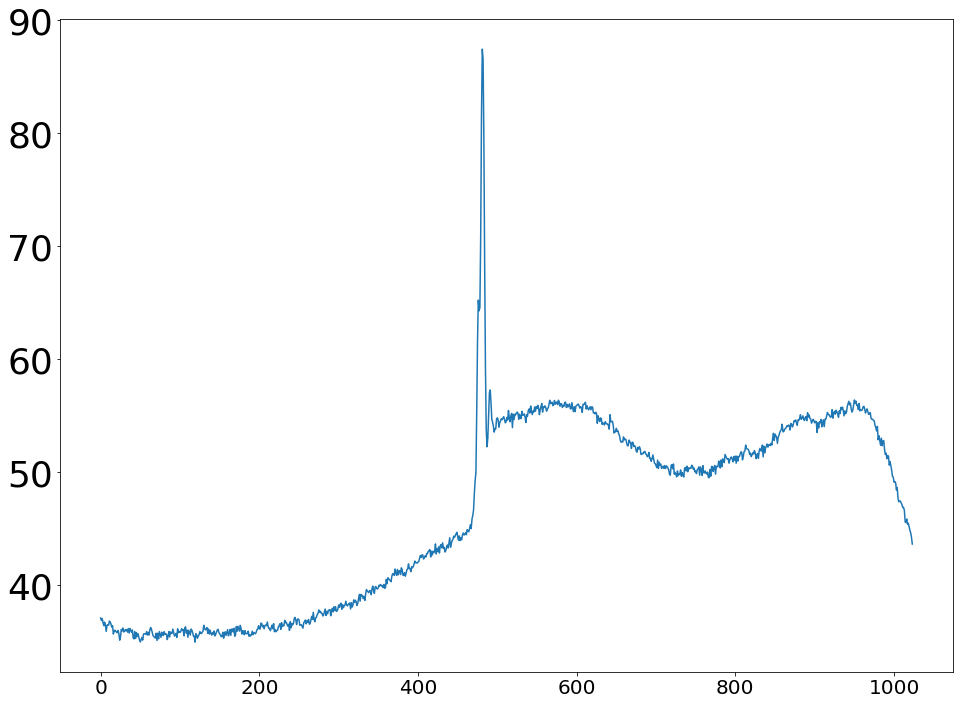

In [237]:
def gaussian(x,params=list):
        norm = (1/((1/2*params[2])*np.sqrt(np.pi * 2)))
        return params[0] * norm * np.exp(-(np.subtract(x,params[1])**2/(2*params[2]**2)))+np.multiply(params[3],x)+params[4]


In [238]:
def gaussian_attr_pos_fit(img,axis=0,low_x_lim=100,up_x_lim=1100,low_y_lim=400,up_y_lim=500,upper_area=300,up_lim_width=15):

    
    def chisquare_1d(function, functionparams, data_x, data_y,data_y_error):
        chisquarevalue=np.sum(np.power(np.divide(np.subtract(function(data_x,functionparams),data_y),data_y_error),2))
        ndf = len(data_y)-len(functionparams)
        #print(ndf)
        return (chisquarevalue, ndf)


    
    def chisquare_gaussian(area,mean,sigma,constant1,constant2):
        return chisquare_1d(function=gaussian,functionparams=[area,mean,sigma,constant1,constant2],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]
   

    area=0
    mean=0
    sigma=0
    constant1=0
    constant2=0
    low_fitrange=50
    up_fitrange=10

    if(axis==0):
        img2 = img.transpose()
        data_y_input = np.mean(img2[low_x_lim:up_x_lim],axis=0) # give y data 
        data_x = np.arange(np.argmax(data_y_input)-low_fitrange,np.argmax(data_y_input)+up_fitrange,1)#range(1024) # give x data
        data_y = np.mean(img2[low_x_lim:up_x_lim],axis=0)[np.argmax(data_y_input)-low_fitrange:np.argmax(data_y_input)+up_fitrange] # give y data 
        data_y_error = np.sqrt(data_y) # give y uncertainty
        low_lim_mean = low_y_lim
        up_lim_mean = up_y_lim
        
    if(axis==1):
        data_x = range(1280) # give x data
        data_y = np.mean(img[low_y_lim:up_y_lim],axis=0) # give y data 
        data_y_error = np.sqrt(data_y) # give y uncertainty
        low_lim_mean = low_x_lim
        up_lim_mean = up_x_lim
        
        
    m=Minuit(chisquare_gaussian, 
             area = 100, # set start parameter
             error_area = 1,
             limit_area= (0,upper_area), # if you want to limit things
             #fix_area = "True", # you can also fix it
             mean = np.argmax(np.mean(img2[low_x_lim:up_x_lim],axis=0)),
             error_mean = 1,
             #fix_mean = "False",
             #limit_mean = (450,490),
             sigma = 4.5,
             error_sigma = 1,
             limit_sigma=(0,up_lim_width),
             constant1 = 0,
             fix_constant1=True,
             error_constant1 = 1,
             constant2 = 55,
             error_constant2 = 1,
             fix_constant2=False,
             errordef = 1,
             print_level=0)
    #print('Now proceed with the fit.')
    m.migrad(ncall=500000)
    #m.minos(), if you need fancy mapping
    chisquare=m.fval
    return m.values['mean'],m

3.571119317182518 8.409343351298629


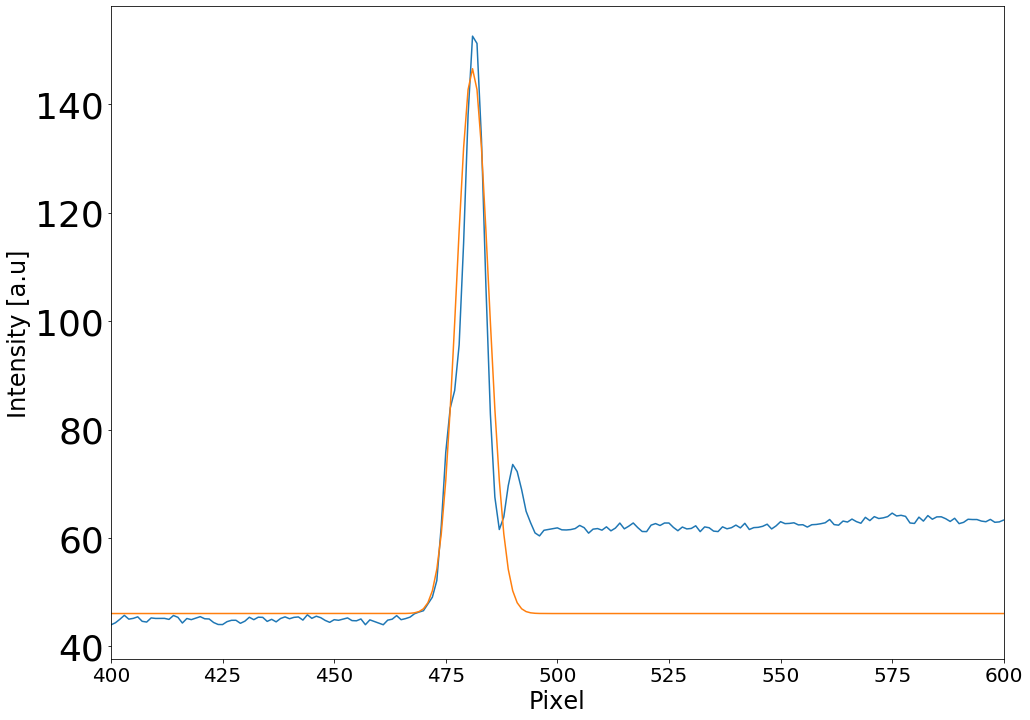

In [273]:
index = 4
m1 = gaussian_attr_pos_fit(img=img[index],upper_area=500)
print(m1[1].values["sigma"],2*np.sqrt(2*np.log(2))*m1[1].values["sigma"])
plt.plot(np.mean(img[index],axis=1))
plt.plot(gaussian(range(1024),params=[m1[1].values["area"],m1[1].values["mean"],m1[1].values["sigma"],m1[1].values["constant1"],m1[1].values["constant2"]]))
plt.xlabel("Pixel")
plt.ylabel("Intensity [a.u]")
plt.xlim(400,600)

plt.show()
#plt.ylim(0,150)

In [274]:
print(m1[0])

481.0009666704697


In [247]:
542.9249058230102*0.46

249.74545667858473

In [376]:
np.argmax(np.mean(img[4],axis=1))

481

In [ ]:
images = load_img_files("/data/new/*")

(650, 75)

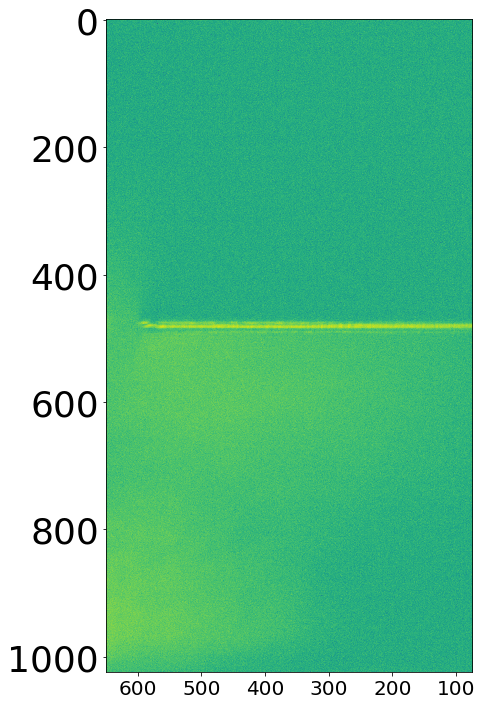

In [385]:
plt.imshow(img[0],norm=LogNorm())
plt.xlim(650,75)

(400, 600)

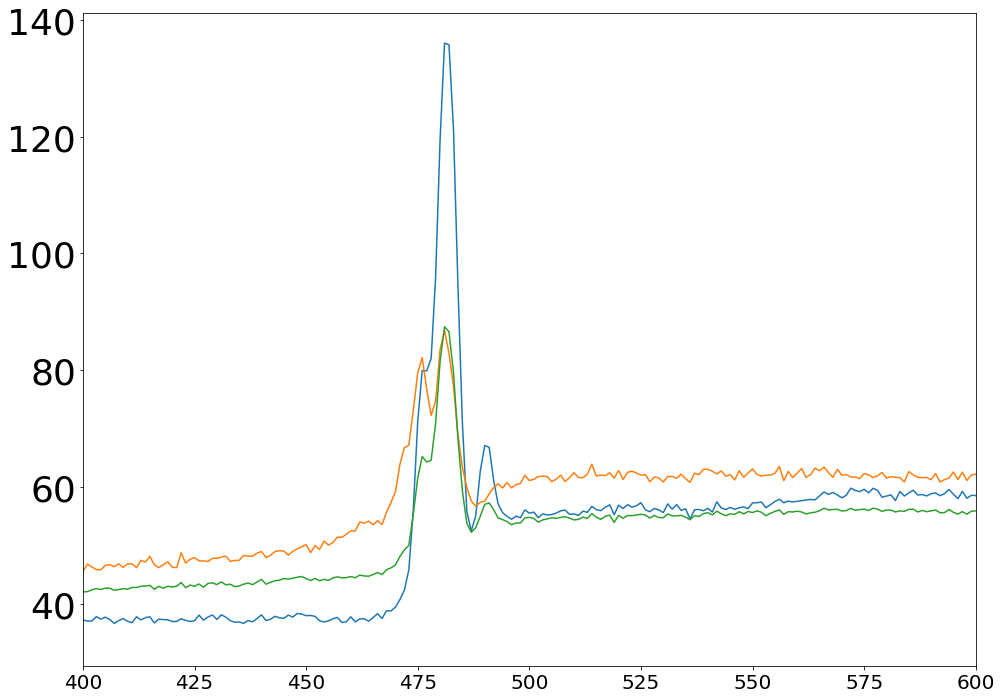

In [382]:
plt.plot(np.mean(img[0].transpose()[200:400],axis=0))
plt.plot(np.mean(img[0].transpose()[550:700],axis=0))
plt.plot(np.mean(img[0].transpose(),axis=0))


plt.xlim(400,600)
#plt.axvline(481)
#plt.axvline(475)

In [304]:
images = load_img_files("/data/SC_data/ImageAnalysis/top_with_and_without_bead_comp_20200225/*")

/data/SC_data/ImageAnalysis/top_with_and_without_bead_comp_20200225/top_with_1354_20_20200227.bmp
/data/SC_data/ImageAnalysis/top_with_and_without_bead_comp_20200225/top_with_bead_20200227.bmp
/data/SC_data/ImageAnalysis/top_with_and_without_bead_comp_20200225/no_bead_m9db_575_20.bmp
/data/SC_data/ImageAnalysis/top_with_and_without_bead_comp_20200225/top_with_bead_575_20.bmp


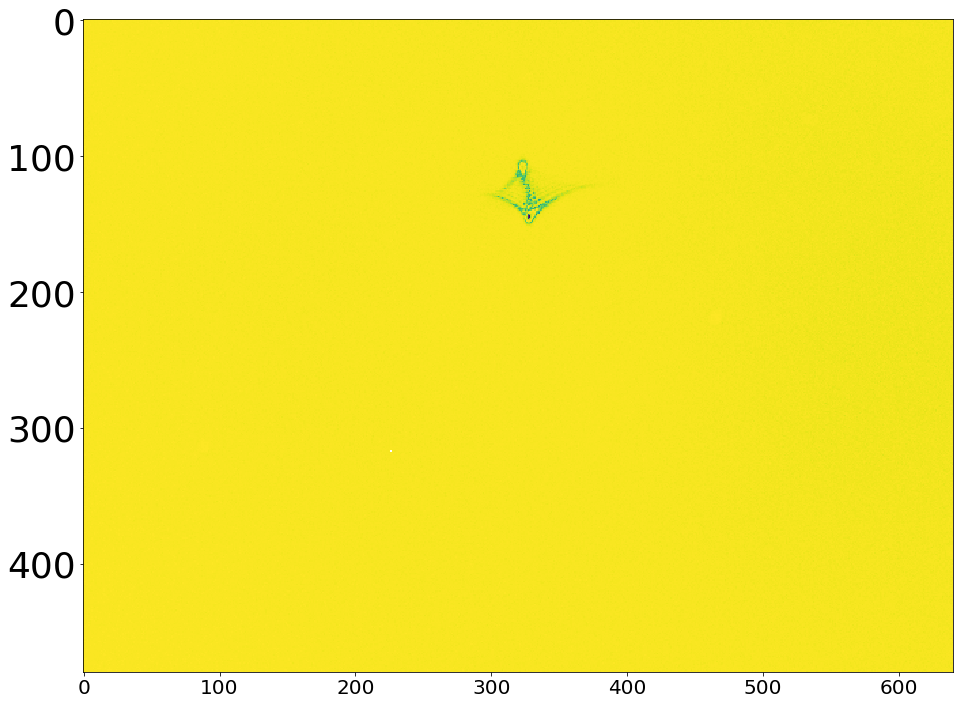

In [373]:
from matplotlib.colors import LogNorm

plt.imshow((images[0]-images[1])-images[3], norm=LogNorm())

In [386]:
np.max(images[2])

255

In [428]:
data_akio = "/data/new_trap/20200226/Bead1/Shaking/202002280953.bmp"
shield_images = load_img_files(data_akio)

/data/new_trap/20200226/Bead1/Shaking/202002280953.bmp


In [399]:
shield_close = load_img_files(data_akio)

/data/new_trap/20200226/Bead1/Shaking/20200228Zset-800000.bmp
/data/new_trap/20200226/Bead1/Shaking/20200228Zset-700000.bmp
/data/new_trap/20200226/Bead1/Shaking/20200228zset-750000.bmp
/data/new_trap/20200226/Bead1/Shaking/20200228Zset-650000.bmp


In [401]:
shield_far =load_img_files(data_akio)

/data/new_trap/20200226/Bead1/Shaking/20200228Zset-650000Shield70.bmp
/data/new_trap/20200226/Bead1/Shaking/20200228Zset-750000Shield70.bmp
/data/new_trap/20200226/Bead1/Shaking/20200228Zset-850000Shield70.bmp
/data/new_trap/20200226/Bead1/Shaking/20200228Zset-70000Shield70.bmp
/data/new_trap/20200226/Bead1/Shaking/20200228Zset-90000Shield70.bmp
/data/new_trap/20200226/Bead1/Shaking/20200228Zset-800000Shield70.bmp


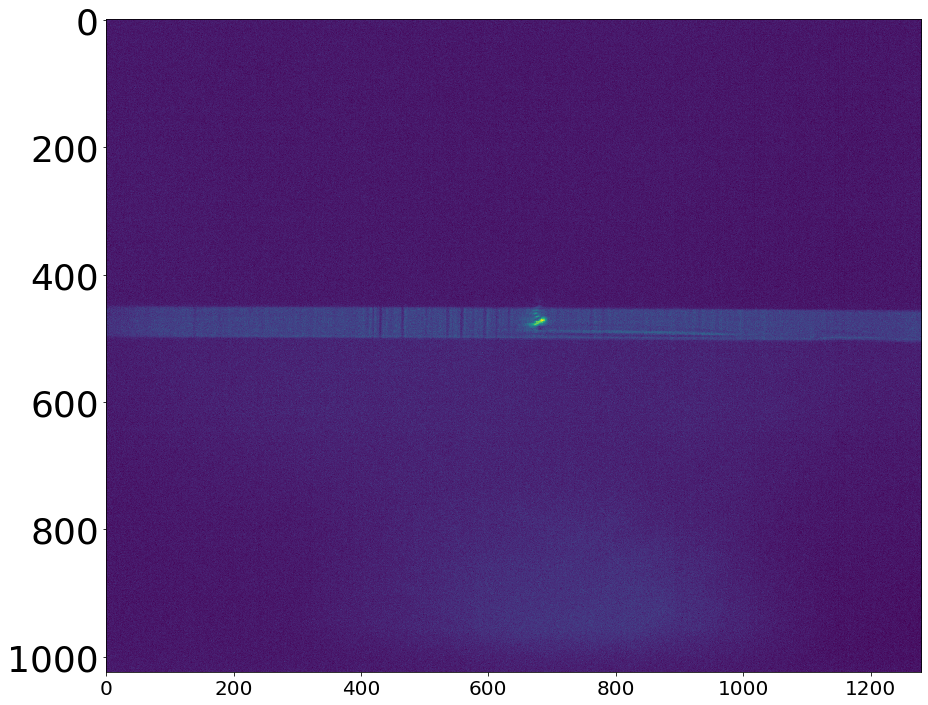

In [429]:
plt.imshow(shield_images[0])

In [404]:
def height_analysis_wrapper(dirname,file_prefix):

    maximum_intensity, mean_intensity, sum_intensity, max_bin_2d, max_bin_1d, max_y_1d_zoom,max_z_1d_zoom = ([] for i in range(7))

    pos_y = [] 
    pos_z =[]
    pos_z_alt =[]
    s = time.time()
    
    files = []
    [files.append(file_) for file_ in os.listdir(dirname) if file_.startswith(file_prefix) if file_.endswith('.npy')]

    for j in tqdm(range(len(files))):
        img = np.load(dirname + "/Shaking%d.npy" %j)
        #img = np.load("/data/new_trap/20200210/Bead2/Shaking/Shaking384/Pictures/Shaking%d.npy" %j)
        maximum_intensity.append(np.max(img))
        mean_intensity.append(np.mean(img))
        sum_intensity.append(np.sum(img))
        max_bin_2d.append(np.argmax(img))
        max_bin_1d.append(np.argmax(np.mean(img, axis=1)))    
        img2 = img.transpose()
        max_y_1d_zoom.append(np.argmax(np.mean(img[400:500],axis=0)))    
        max_z_1d_zoom.append(np.argmax(np.mean(img2[600:700],axis=0)))    
        pos_z.append(gaussian_bead_pos_fit(img,axis=0))#,low_x_lim=550,up_x_lim=750,low_y_lim=420,up_y_lim=550,upper_area=1500,up_lim_width=10))
        pos_y.append(gaussian_bead_pos_fit(img,axis=1))#,low_x_lim=550,up_x_lim=750,low_y_lim=420,up_y_lim=550,upper_area=1500,up_lim_width=10))    
        pos_z_alt.append(gaussian_bead_pos_fit(img,axis=0,up_lim_width=10))#,low_x_lim=550,up_x_lim=750,low_y_lim=420,up_y_lim=550,upper_area=1500,up_lim_width=10))    

        #pos.append(gaussian_bead_pos_fit(img2))
    e = time.time()
    print("Time passed %d" %(e-s))                      
    return pos_z,pos_y,pos_z_alt,maximum_intensity, mean_intensity, sum_intensity, max_bin_2d, max_bin_1d, max_y_1d_zoom,max_z_1d_zoom

In [409]:
def gaussian_bead_pos_fit(img,axis=0,low_x_lim=500,up_x_lim=800,low_y_lim=420,up_y_lim=550,upper_area=300,up_lim_width=20):

    def chisquare_1d(function, functionparams, data_x, data_y,data_y_error):
        chisquarevalue=np.sum(np.power(np.divide(np.subtract(function(data_x,functionparams),data_y),data_y_error),2))
        ndf = len(data_y)-len(functionparams)
        #print(ndf)
        return (chisquarevalue, ndf)

    def gaussian(x,params=list):
        norm = (1/((1/2*params[2])*np.sqrt(np.pi * 2)))
        return params[0] * norm * np.exp(-(np.subtract(x,params[1])**2/(2*params[2]**2)))+params[3]

    
    def chisquare_gaussian(area,mean,sigma,constant):
        return chisquare_1d(function=gaussian,functionparams=[area,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]
   

    area=0
    mean=0
    sigma=0
    constant=0
    
    if(axis==0):
        img2 = img.transpose()
        data_x = range(1024) # give x data
        data_y = np.mean(img2[low_x_lim:up_x_lim],axis=0) # give y data 
        data_y_error = np.sqrt(data_y) # give y uncertainty
        low_lim_mean = low_y_lim
        up_lim_mean = up_y_lim
        
    if(axis==1):
        data_x = range(1280) # give x data
        data_y = np.mean(img[low_y_lim:up_y_lim],axis=0) # give y data 
        data_y_error = np.sqrt(data_y) # give y uncertainty
        low_lim_mean = low_x_lim
        up_lim_mean = up_x_lim
        
        
    m=Minuit(chisquare_gaussian, 
             area = 100, # set start parameter
             error_area = 1,
             limit_area= (0,upper_area), # if you want to limit things
             #fix_area = "True", # you can also fix it
             mean = np.argmax(data_y),
             error_mean = 1,
             #fix_mean = "False",
             limit_mean = (low_lim_mean,up_lim_mean),
             sigma = 15,
             error_sigma = 1,
             limit_sigma=(0,up_lim_width),
             constant = 10,
             error_constant = 1,
             #fix_constant=0,
             errordef = 1,
             print_level=0)
    #print('Now proceed with the fit.')
    m.migrad(ncall=500000)
    #m.minos(), if you need fancy mapping
    chisquare=m.fval
    return m.values['mean']#,m

In [421]:
sc_h = [1024*0.46-0.46*gaussian_bead_pos_fit(shield_close[o]) for o in range(len(shield_close))]

In [422]:
sf_h =[1024*0.46-0.46*gaussian_bead_pos_fit(shield_far[o]) for o in range(len(shield_far))]

In [419]:
sc = [800000,700000,750000,650000]

In [426]:
sf = [650000,750000,850000,700000,900000,800000]

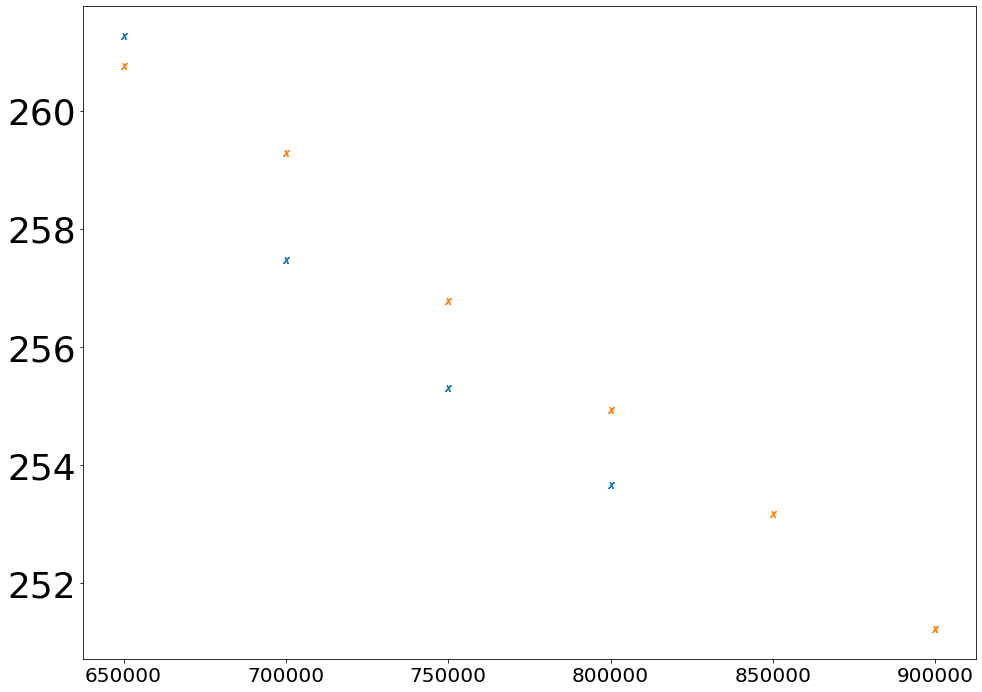

In [427]:
plt.plot(sc,sc_h,marker="$X$",linestyle="",size=15p)
plt.plot(sf,sf_h,marker="$X$",linestyle="")


In [432]:
data_akio = "/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/attr_*.bmp"
attr_images = load_img_files(data_akio)

/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/attr_370_47_250_20.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/attr_371_47_250_20.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/attr_372_47_250_20.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/attr_373_47_250_20.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/attr_374_47_250_20.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/attr_375_47_250_20.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/attr_375_47_500_20.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/attr_376_47_250_20.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/attr_377_47_250_20.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/attr_378_47_250_20.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/attr_379_47_250_20.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/attr_380_47_250_20.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/attr_381_47_250_20.bmp
/data/new_trap/20200226/B

In [434]:
a = [1024*0.46-0.46*gaussian_bead_pos_fit(attr_images[o]) for o in range(len(attr_images))]

In [442]:
a

[251.89439119081112,
 251.91926353358508,
 251.22936475602128,
 253.12160038105168,
 251.67953372051397,
 251.8414306872638,
 251.85723162073293,
 252.33423318416635,
 252.21457227817638,
 252.40900945937173,
 251.93033609954546,
 251.5297957703001,
 252.4142474074156,
 252.62493977552364,
 251.36271968651246,
 251.97633894806862,
 252.3037098518839,
 252.46411987345326,
 251.46304012538732,
 251.82536499234794,
 251.89289980383887,
 252.14487760531347]

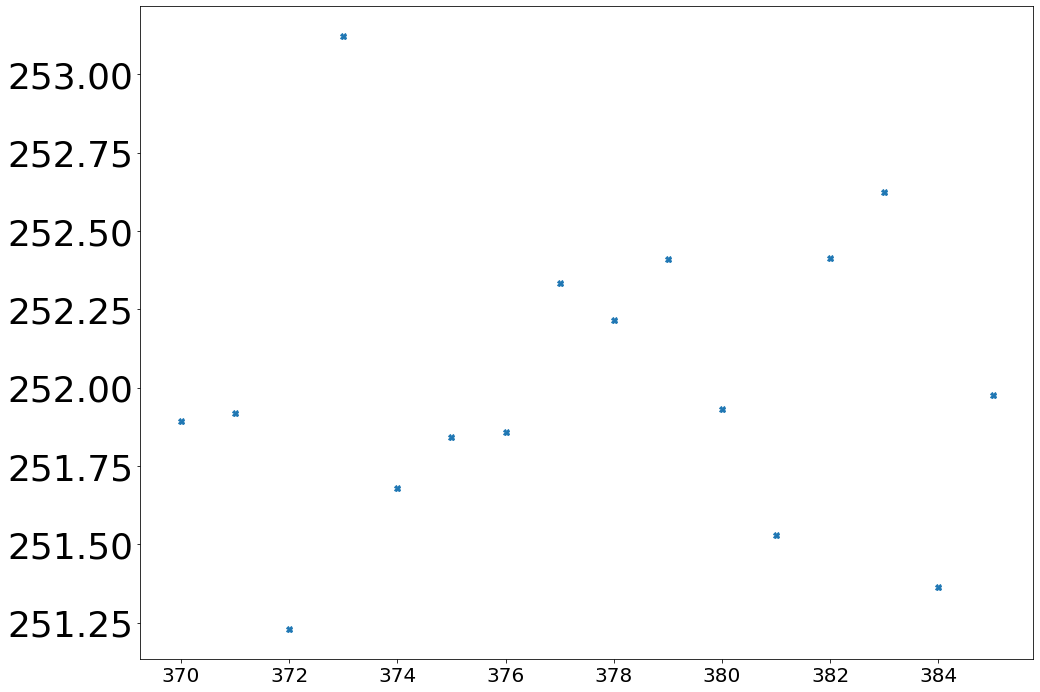

In [441]:
x = np.arange(370,386,1)
plt.plot(x,a[0:16],linestyle="",marker="X")

In [470]:
data_akio = "/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/shield*.bmp"
shield_only_images = load_img_files(data_akio)

/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/shield_545_rep.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/shield_545_rep2.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/shield_55_250_20_20200228.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/shield_56_250_20_20200228.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/shield_57_250_20_20200228.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/shield_58_250_20_20200228.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/shield_59_250_20_20200228.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/shield_60_250_20_20200228.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/shield_65_250_20_20200228.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/shield_70_250_20_20200228.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/shield_75_250_20_20200228.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/shield_545_250_20_20200228.bmp


In [476]:
aa = [1024*0.46-0.46*gaussian_bead_pos_fit(shield_only_images[o]) for o in np.arange(2,len(shield_only_images),1)]
bb=[np.max(shield_only_images[o]) for o in np.arange(2,len(shield_only_images),1)]

In [473]:
aa
dis = [55,56,57,58,59,60,65,70,75,54.5]

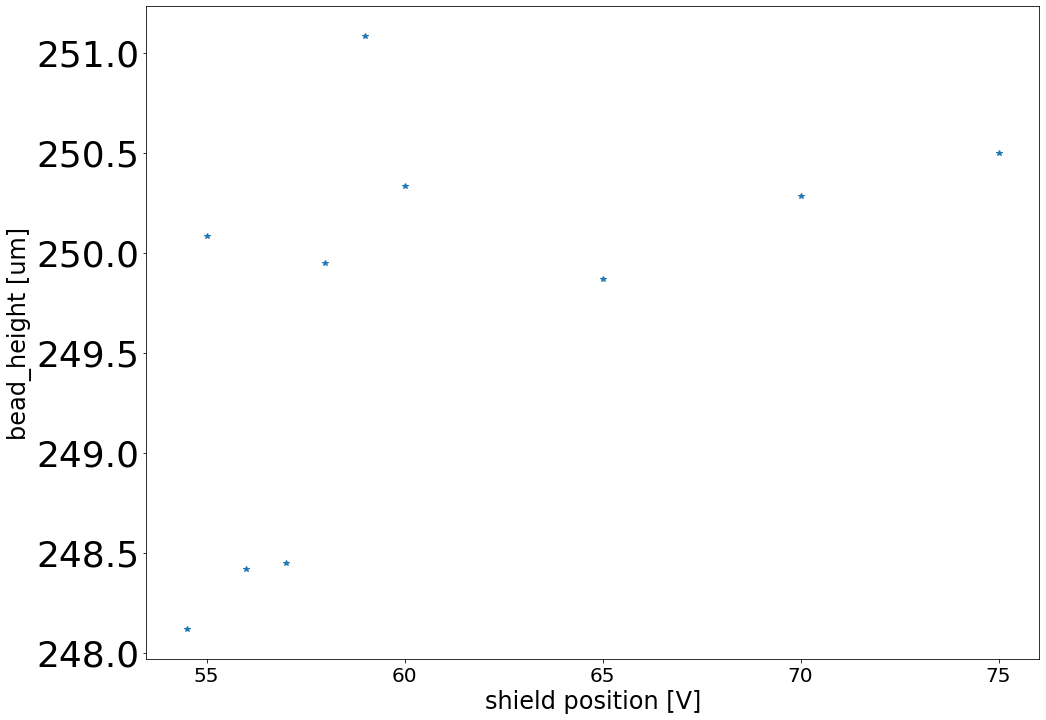

In [483]:
plt.plot(dis,aa,marker="*",linestyle="")
plt.ylabel("bead_height [um]")
plt.xlabel("shield position [V]")
plt.savefig("Results/Height_Shield_Variation.png",dpi=300,bbox_inches="tight")
plt.show()

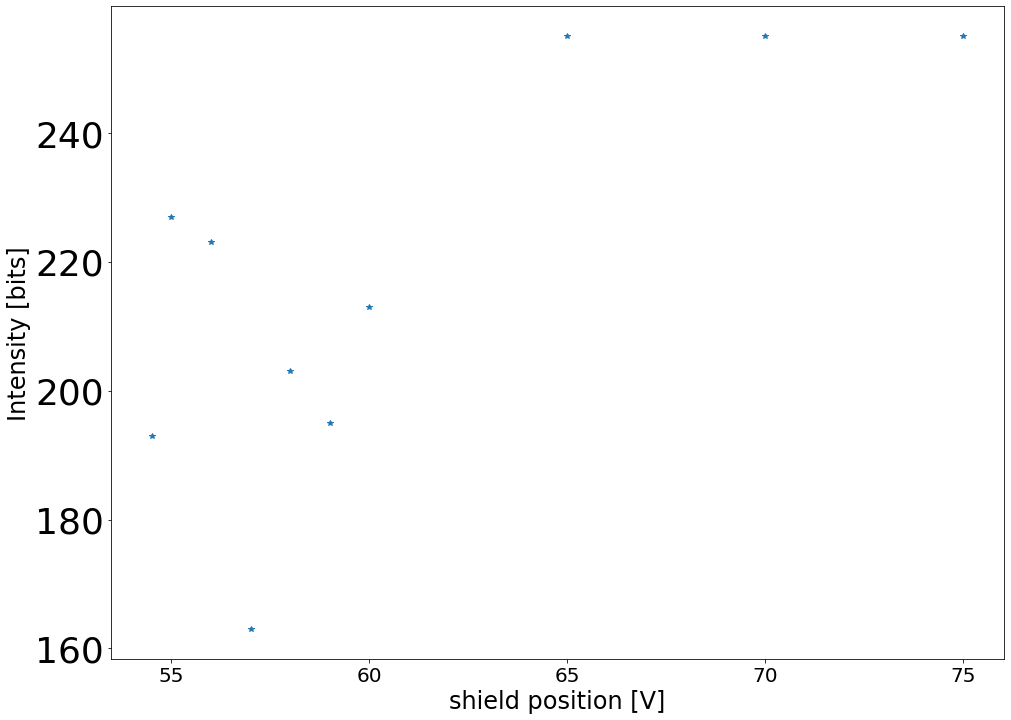

In [484]:
plt.plot(dis,bb,marker="*",linestyle="")
plt.ylabel("Intensity [bits]")
plt.xlabel("shield position [V]")
plt.savefig("Results/intensity_Shield_Variation.png",dpi=300,bbox_inches="tight")
plt.show()

In [455]:
data_akio = "/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/zset*.bmp"
zset_images = load_img_files(data_akio)

/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/zset_82_k_250_20_20200228.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/zset_83_k_250_20_20200228.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/zset_84_k_250_20_20200228.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/zset_85_k_250_20_20200228.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/zset_86_k_250_20_20200228.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/zset_87_k_250_20_20200228.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/zset_88_k_250_20_20200228.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/zset_89_k_250_20_20200228.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/zset_90_k_250_20_20200228.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/zset_91_k_250_20_20200228.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/zset_92_k_250_20_20200228.bmp


In [456]:
aaa = [1024*0.46-0.46*gaussian_bead_pos_fit(zset_images[o]) for o in range(len(zset_images))]

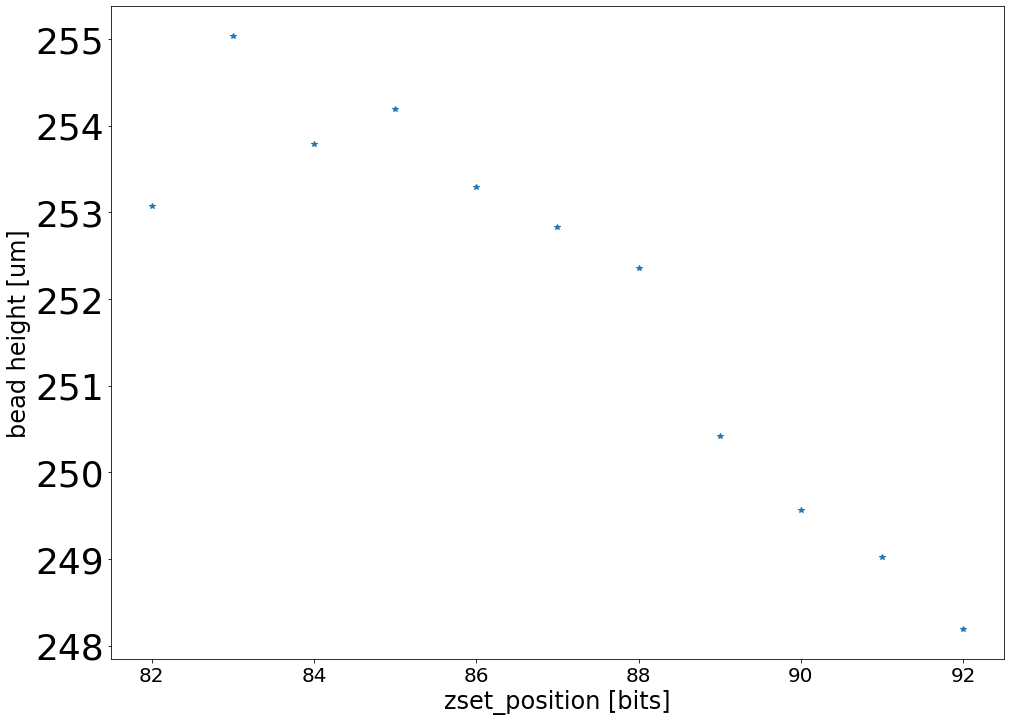

In [482]:
x=np.arange(82,93,1)
plt.plot(x,aaa,marker="*",linestyle="")
plt.ylabel("bead height [um]")
plt.xlabel("zset_position [bits]")
plt.savefig("Results/Height_zset_const_shield.png",dpi=300,bbox_inches="tight")
plt.show()

In [463]:
data_akio = "/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/*rep*.bmp"
shield_rep_images = load_img_files(data_akio)

/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/shield_545_rep.bmp
/data/new_trap/20200226/Bead1/Shaking/Height_Puzzle/shield_545_rep2.bmp


In [464]:
aaaa = [1024*0.46-0.46*gaussian_bead_pos_fit(shield_rep_images[o]) for o in range(len(shield_rep_images))]

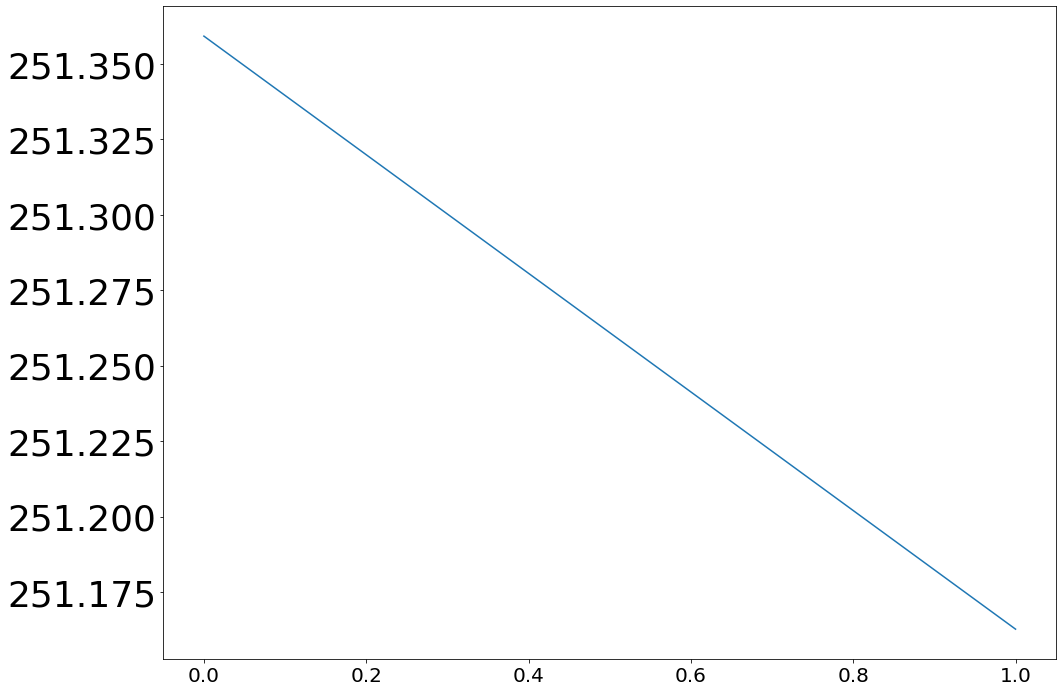

In [465]:
plt.plot(aaaa)